In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import category_encoders as ce
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import ConvLSTM2D, Dense, Flatten, Dropout, BatchNormalization, LeakyReLU, Reshape, Embedding, Concatenate, Input, Layer
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, f1_score, fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras import backend as K
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.ensemble import RandomForestClassifier

In [2]:
df=pd.read_csv('C:/Users/vnsat/OneDrive/Desktop/M.Tech/Main Project/Final_Dataset_1-VNST.csv')

In [3]:
df.shape

(2666, 23)

In [4]:
for col in df.columns:
    print(f"{col}: {df[col].dtype}")

State: object
Account length: int64
Area code: int64
International plan: object
Voice mail plan: object
Number vmail messages: int64
Total day minutes: float64
Total day calls: int64
Total day charge: float64
Total eve minutes: float64
Total eve calls: int64
Total eve charge: float64
Total night minutes: float64
Total night calls: int64
Total night charge: float64
Total intl minutes: float64
Total intl calls: int64
Total intl charge: float64
Customer service calls: int64
Churn: bool
District: object
District_Code: object
Area: object


In [5]:
df.drop(['State','Customer service calls','District','District_Code','Area'],axis=1,inplace=True)

In [6]:
nan_counts = df.isnull().sum()
print("Columns with NaN values and their count:\n", nan_counts[nan_counts > 0])

Columns with NaN values and their count:
 Series([], dtype: int64)


In [7]:
def total_missing_count(col):
    is_real_nan = col.isnull().sum()
    is_fake_nan = col.astype(str).str.strip().str.lower().isin(['', 'nan', 'none', 'null','Nan','NaN']).sum()
    return is_real_nan + is_fake_nan

In [8]:
for col in df.select_dtypes(include='object').columns:
    count = total_missing_count(df[col])
    print(f"{col}: {count} total missing (real + fake)")

International plan: 0 total missing (real + fake)
Voice mail plan: 0 total missing (real + fake)


In [9]:
df['Total day minutes'] = df['Total day minutes'].astype('int64')
df['Total eve minutes'] = df['Total eve minutes'].astype('int64')
df['Total night minutes'] = df['Total night minutes'].astype('int64')
df['Total intl minutes'] = df['Total intl minutes'].astype('int64')

In [10]:
for col in df.select_dtypes(include='object').columns:
    print(df[col].value_counts())
    print("-" * 25)

International plan
No     2396
Yes     270
Name: count, dtype: int64
-------------------------
Voice mail plan
No     1933
Yes     733
Name: count, dtype: int64
-------------------------


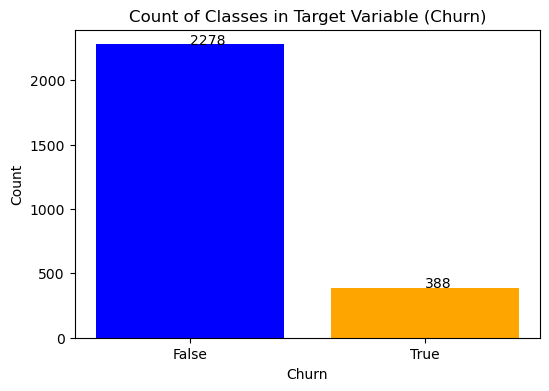

In [11]:
target_counts = df['Churn'].value_counts()
plt.figure(figsize=(6,4))
bars=plt.bar(target_counts.index.astype(str), target_counts.values, color=['blue', 'orange'])
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(bar.get_height()))
plt.xlabel('Churn')
plt.ylabel('Count')
plt.title('Count of Classes in Target Variable (Churn)')
plt.show()

In [12]:
object_cols = df.select_dtypes(include='object').columns.tolist()
print(object_cols)
binary_encoder = ce.BinaryEncoder(cols=object_cols)
binary_encoded_df = binary_encoder.fit_transform(df[object_cols])
df = df.drop(columns=['International plan','Voice mail plan'])
df = pd.concat([df, binary_encoded_df], axis=1)

['International plan', 'Voice mail plan']


In [13]:
print(df['Churn'].unique())

[False  True]


In [14]:
df['Churn']=df['Churn'].astype(int)

In [15]:
X = df.drop(columns=['Churn'])
y = df['Churn']

In [16]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=36)
X_train_real, X_val_real, y_train_real, y_val_real = train_test_split(
    X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=36)

In [17]:
print("Test set class distribution:", Counter(y_test))

Test set class distribution: Counter({0: 456, 1: 78})


In [18]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

In [19]:
pca = PCA()
pca.fit(scaled_data)

PCA()

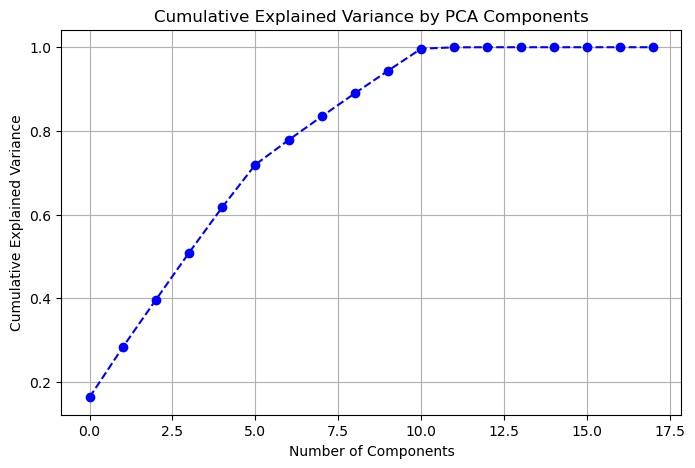

In [20]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(8, 5))
plt.plot(cumulative_variance, marker='o', linestyle='--', color='b')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [21]:
X_train_scaled = scaler.fit_transform(X_train_real)
X_val_scaled = scaler.transform(X_val_real)
X_test_scaled = scaler.transform(X_test)

In [22]:
n_components = 17
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [23]:
print(f"Shape of PCA components: {pca.components_.shape}")
print(f"Shape of X columns: {len(X.columns)}")

Shape of PCA components: (17, 18)
Shape of X columns: 18


In [24]:
X_train_pca_reshaped = X_train_pca.reshape((X_train_pca.shape[0], 1, 1, X_train_pca.shape[1], 1))
X_val_pca_reshaped = X_val_pca.reshape((X_val_pca.shape[0], 1, 1, X_val_pca.shape[1], 1))
X_test_pca_reshaped = X_test_pca.reshape((X_test_pca.shape[0], 1, 1, X_test_pca.shape[1], 1))

In [25]:
selected_column_names = X.columns.tolist()
components_df = pd.DataFrame(pca.components_, columns=selected_column_names)
top_features = components_df.abs().sum(axis=0).nlargest(n_components).index.tolist()
print("Top 17 Features after PCA:", top_features)

Top 17 Features after PCA: ['Total intl minutes', 'Total intl charge', 'Total eve minutes', 'Total eve charge', 'Total day minutes', 'Total day charge', 'Account length', 'Total night charge', 'Total night minutes', 'Total night calls', 'International plan_1', 'International plan_0', 'Total day calls', 'Total intl calls', 'Total eve calls', 'Number vmail messages', 'Voice mail plan_1']


In [26]:
X_minority = X_train_pca[y_train_real == 1]
y_minority = y_train_real[y_train_real == 1]
X_minority = X_minority.reshape((X_minority.shape[0], 1, 1, X_minority.shape[1], 1))
latent_dim = 100
n_features = X_train_pca.shape[1]
n_classes = 2

In [27]:
def build_generator(latent_dim, n_classes, n_features):
    noise_input = Input(shape=(latent_dim,), name="noise_input")
    label_input = Input(shape=(1,), dtype='int32', name="label_input")

    label_embedding = Embedding(input_dim=n_classes, output_dim=latent_dim)(label_input)
    label_embedding = Flatten()(label_embedding)

    merged_input = Concatenate()([noise_input, label_embedding])

    x = Dense(256)(merged_input)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)

    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)

    x = Dense(1024)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)

    x = Dropout(0.3)(x)

    x = Dense(n_features, activation='tanh')(x)
    output = Reshape((1, 1, n_features, 1))(x)

    return Model([noise_input, label_input], output, name="Generator")

In [28]:
def build_discriminator(n_classes, n_features):
    data_input = Input(shape=(1, 1, n_features, 1))
    label_input = Input(shape=(1,), dtype='int32')

    x = Flatten()(data_input)

    label_embedding = Embedding(n_classes, n_features)(label_input)
    label_embedding = Flatten()(label_embedding)

    merged = Concatenate()([x, label_embedding])

    x = Dense(512)(merged)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.4)(x)

    x = Dense(256)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.4)(x)

    x = Dense(128)(x)
    x = LeakyReLU(alpha=0.2)(x)

    output = Dense(1, activation='sigmoid')(x)

    return Model([data_input, label_input], output, name="Discriminator")

In [29]:
generator = build_generator(latent_dim, n_classes, n_features)
discriminator = build_discriminator(n_classes, n_features)
discriminator.compile(optimizer=Adam(learning_rate=0.0001, beta_1=0.5), loss='binary_crossentropy', metrics=['accuracy'])
noise = Input(shape=(latent_dim,))
label = Input(shape=(1,))
generated_data = generator([noise, label])
discriminator.trainable = False
validity = discriminator([generated_data, label])
cgan = Model([noise, label], validity)
cgan.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')

In [30]:
def generate_real_samples(n_samples):
    idx = np.random.randint(0, X_minority.shape[0], n_samples)
    X_real = X_minority[idx]
    labels = y_train_real.iloc[idx].values.reshape(-1, 1)  # Ensure shape is (n_samples, 1)
    y_real = np.ones((n_samples, 1))*0.9    # Label for real images
    return X_real, y_real, labels

In [31]:
def generate_fake_samples(n_samples):
    noise = np.random.randn(n_samples, latent_dim)
    labels = np.random.randint(0, n_classes, size=(n_samples, 1))  # Random class labels
    X_fake = generator.predict([noise, labels])
    y_fake = np.zeros((n_samples, 1))+0.1  # Label for fake images
    return X_fake, y_fake, labels

In [32]:
#epochs = 1000
#batch_size = 64
n_class_0 = (y_train_real == 0).sum()
n_class_1 = (y_train_real == 1).sum()
n_to_generate = n_class_0 - n_class_1
print(f"Generating {n_to_generate} synthetic samples for class 1...")

@tf.function
def train_step(X_real, y_real, labels_real, batch_size):
    noise = tf.random.normal([batch_size, latent_dim])
    sampled_labels = tf.random.uniform([batch_size, 1], maxval=n_classes, dtype=tf.int32)

    with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:
        generated_data = generator([noise, sampled_labels], training=True)

        real_output = discriminator([X_real, labels_real], training=True)
        fake_output = discriminator([generated_data, sampled_labels], training=True)

        disc_loss_real = tf.keras.losses.binary_crossentropy(tf.ones_like(real_output)*0.9, real_output)
        disc_loss_fake = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output)+0.1, fake_output)
        disc_loss = 0.5 * (disc_loss_real + disc_loss_fake)

        gen_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

    disc_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    gen_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    return tf.reduce_mean(disc_loss), tf.reduce_mean(gen_loss)

Generating 1209 synthetic samples for class 1...


In [33]:
def train_gan(X_minority, y_train_real, epochs=1000, batch_size=64):
    for epoch in range(epochs):
        # Prepare real and fake batches for discriminator
        X_real, y_real, labels_real = generate_real_samples(X_minority, y_train_real, batch_size // 2)
        X_fake, y_fake, labels_fake = generate_fake_samples(batch_size // 2)

        # Train discriminator
        d_loss_real = discriminator.train_on_batch([X_real, labels_real], y_real)
        d_loss_fake = discriminator.train_on_batch([X_fake, labels_fake], y_fake)
        d_loss = 0.5 * (d_loss_real[0] + d_loss_fake[0])

        # Train generator (via combined model)
        noise = np.random.randn(batch_size, latent_dim)
        sampled_labels = np.random.randint(0, n_classes, size=(batch_size, 1))
        y_gan = np.ones((batch_size, 1))  # try to fool discriminator
        g_loss = cgan.train_on_batch([noise, sampled_labels], y_gan)

        if epoch % 50 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch}/{epochs} | D Loss: {d_loss:.4f} | G Loss: {g_loss:.4f}")

In [34]:
n_synthetic = X_minority.shape[0]
#noise = np.random.randn(n_synthetic, latent_dim)
#labels = np.ones((n_synthetic, 1))  # Assuming you want minority class label 1
#synthetic_samples = generator.predict([noise, labels]).reshape(n_synthetic, n_features)

noise = np.random.randn(n_to_generate, latent_dim)
labels = np.ones((n_to_generate, 1))  # Label = 1 for minority class
synthetic_samples = generator.predict([noise, labels])
synthetic_samples = synthetic_samples.reshape(n_to_generate, n_features)

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [35]:
X_train_combined = np.vstack((X_train_pca, synthetic_samples))
#synthetic_labels = np.ones((synthetic_samples.shape[0], 1))
synthetic_labels = np.ones((n_to_generate, 1))
y_train_combined = np.vstack((y_train_real.values.reshape(-1, 1), synthetic_labels)).ravel()
X_augmented = X_train_combined.reshape((X_train_combined.shape[0], 1, 1, n_features, 1))
X_val_real_reshaped = X_val_pca.reshape((X_val_pca.shape[0], 1, 1, n_features, 1))
X_test_aligned = X_test_pca.reshape((X_test_pca.shape[0], 1, 1, n_features, 1))
print("After augmentation:", Counter(y_train_combined))

After augmentation: Counter({1.0: 1457, 0.0: 1457})


In [36]:
y_augmented = np.vstack((y_train_real.values.reshape(-1, 1), synthetic_labels))
y_augmented = y_augmented.ravel()

In [37]:
y_augmented = y_augmented.astype(int)
unique_classes = np.unique(y_augmented)
class_weights = compute_class_weight(class_weight='balanced', classes=unique_classes, y=y_augmented.ravel())
class_weight_dict = {0: 1.0, 1: 1.3875}
print(Counter(y_augmented))

Counter({1: 1457, 0: 1457})


In [38]:
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = K.clip(y_pred, 1e-7, 1. - 1e-7)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        loss = -alpha * K.pow(1. - pt, gamma) * K.log(pt)
        return K.mean(loss)
    return focal_loss_fixed

In [39]:
class AttentionLayer(Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], 1),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(input_shape[1], 1),
                                 initializer='zeros', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        alpha = K.softmax(e, axis=1)
        context = x * alpha
        return K.sum(context, axis=1)


In [ ]:
def gwo_optimize(model_builder, X_train, y_train, X_val, y_val, n_features, n_wolves=5, n_iter=10):
    # Define search space: [lr, dropout1, dropout2, l2]
    lb = [1e-4, 0.1, 0.1, 1e-5]
    ub = [1e-2, 0.5, 0.5, 1e-2]
    dim = len(lb)

    wolves = np.random.uniform(lb, ub, (n_wolves, dim))
    fitness = np.zeros(n_wolves)

    def evaluate(pos):
        lr, d1, d2, l2_val = pos
        model = model_builder(n_features, lr, d1, d2, l2_val)
        model.fit(X_train, y_train, epochs=3, verbose=0, batch_size=32)
        y_pred = model.predict(X_val).round()
        return 1 - accuracy_score(y_val, y_pred)  # minimize error

    # Initial fitness
    for i in range(n_wolves):
        fitness[i] = evaluate(wolves[i])

    for t in range(n_iter):
        # Sort wolves based on fitness
        sorted_idx = np.argsort(fitness)
        alpha = wolves[sorted_idx[0]]
        beta  = wolves[sorted_idx[1]]
        delta = wolves[sorted_idx[2]]

        a = 2 - t * (2 / n_iter)  # linearly decrease

        for i in range(n_wolves):
            for j in range(dim):
                r1, r2 = np.random.rand(), np.random.rand()
                A1 = 2 * a * r1 - a
                C1 = 2 * r2
                D_alpha = abs(C1 * alpha[j] - wolves[i][j])
                X1 = alpha[j] - A1 * D_alpha

                r1, r2 = np.random.rand(), np.random.rand()
                A2 = 2 * a * r1 - a
                C2 = 2 * r2
                D_beta = abs(C2 * beta[j] - wolves[i][j])
                X2 = beta[j] - A2 * D_beta

                r1, r2 = np.random.rand(), np.random.rand()
                A3 = 2 * a * r1 - a
                C3 = 2 * r2
                D_delta = abs(C3 * delta[j] - wolves[i][j])
                X3 = delta[j] - A3 * D_delta

                wolves[i][j] = np.clip((X1 + X2 + X3) / 3, lb[j], ub[j])

            fitness[i] = evaluate(wolves[i])
        print(f"Iter {t+1}/{n_iter}, Best Fitness: {min(fitness):.4f}")

    best_idx = np.argmin(fitness)
    best_params = wolves[best_idx]
    return best_params

In [40]:
def build_convlstm_model():
    inp = Input(shape=(1, 1, n_features, 1))
    x = ConvLSTM2D(filters=64, kernel_size=(1, 3), activation='relu', padding='same')(inp)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = AttentionLayer()(x)
    x = Flatten()(x)
    x = Dense(128, kernel_regularizer=l2(0.0009))(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.5)(x)
    x = Dense(64, kernel_regularizer=l2(0.0009))(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.4)(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])
    return model


In [41]:
convlstm = build_convlstm_model()
print(convlstm.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 1, 1, 17, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d (ConvLSTM2D)             │ (None, 1, 17, 64)           │          50,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 1, 17, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1, 17, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer (AttentionLayer)     │ (None, 17, 64)              │              65 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 1088)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │         139,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 198,210 (774.26 KB)

 Trainable params: 198,082 (773.76 KB)

 Non-trainable params: 128 (512.00 B)

None


In [42]:
X_val_real_reshaped = X_val_pca.reshape((X_val_pca.shape[0], 1, 1, X_val_pca.shape[1], 1))

In [43]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)
convlstm_history = convlstm.fit(
    X_augmented, 
    y_augmented, 
    epochs=20, 
    batch_size=128, 
    validation_data=(X_val_real_reshaped, y_val_real),
    class_weight=class_weight_dict,
    callbacks=[early_stop]
)

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.7468 - loss: 0.3194 - val_accuracy: 0.5457 - val_loss: 0.2694
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9073 - loss: 0.2356 - val_accuracy: 0.6464 - val_loss: 0.2156
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9145 - loss: 0.1819 - val_accuracy: 0.7073 - val_loss: 0.1743
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9186 - loss: 0.1417 - val_accuracy: 0.6792 - val_loss: 0.1441
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9251 - loss: 0.1153 - val_accuracy: 0.7471 - val_loss: 0.1209
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9220 - loss: 0.0927 - val_accuracy: 0.7213 - val_loss: 0.1047
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9235 - loss: 0.0773 - val_accuracy: 0.7424 - val_loss: 0.0911
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9370 - loss: 0.0651 - val_accuracy: 0.7143 - v

In [44]:
X_test_aligned = X_test_pca.reshape((X_test_pca.shape[0], 1, 1, X_test_pca.shape[1], 1))

In [45]:
print("X_test_aligned shape:", X_test_aligned.shape)
print("y_test shape:", y_test.shape)

X_test_aligned shape: (534, 1, 1, 17, 1)
y_test shape: (534,)


In [46]:
y_val_probs = convlstm.predict(X_val_real_reshaped)

thresholds = np.arange(0.1, 1.0, 0.05)
best_thresh = 0.5
best_f2 = 0

for thresh in thresholds:
    y_val_pred = (y_val_probs > thresh).astype(int)
    f2 = fbeta_score(y_val_real, y_val_pred, beta=2)
    if f2 > best_f2:
        best_f2 = f2
        best_thresh = thresh

print(f"Best threshold for F2: {best_thresh} with score: {best_f2}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
Best threshold for F2: 0.45000000000000007 with score: 0.5374592833876222


In [47]:
y_pred = (convlstm.predict(X_test_aligned) > best_thresh).astype(int)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [48]:
report = classification_report(y_test, y_pred, output_dict=True)
print("Classification Report:\n", report)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy:\n",accuracy_score(y_test,y_pred))

Classification Report:
 {'0': {'precision': 0.9230769230769231, 'recall': 0.9210526315789473, 'f1-score': 0.9220636663007684, 'support': 456.0}, '1': {'precision': 0.5443037974683544, 'recall': 0.5512820512820513, 'f1-score': 0.5477707006369427, 'support': 78.0}, 'accuracy': 0.8670411985018727, 'macro avg': {'precision': 0.7336903602726388, 'recall': 0.7361673414304993, 'f1-score': 0.7349171834688555, 'support': 534.0}, 'weighted avg': {'precision': 0.8677505114711772, 'recall': 0.8670411985018727, 'f1-score': 0.8673916600802095, 'support': 534.0}}
Confusion Matrix:
 [[420  36]
 [ 35  43]]
Accuracy:
 0.8670411985018727


In [49]:
acc = report['accuracy']
prec = report['weighted avg']['precision']
rec = report['weighted avg']['recall']
f1 = report['weighted avg']['f1-score']

print(f"acc = {acc:.4f}")
print(f"prec = {prec:.4f}")
print(f"rec = {rec:.4f}")
print(f"f1 = {f1:.4f}")

acc = 0.8670
prec = 0.8678
rec = 0.8670
f1 = 0.8674


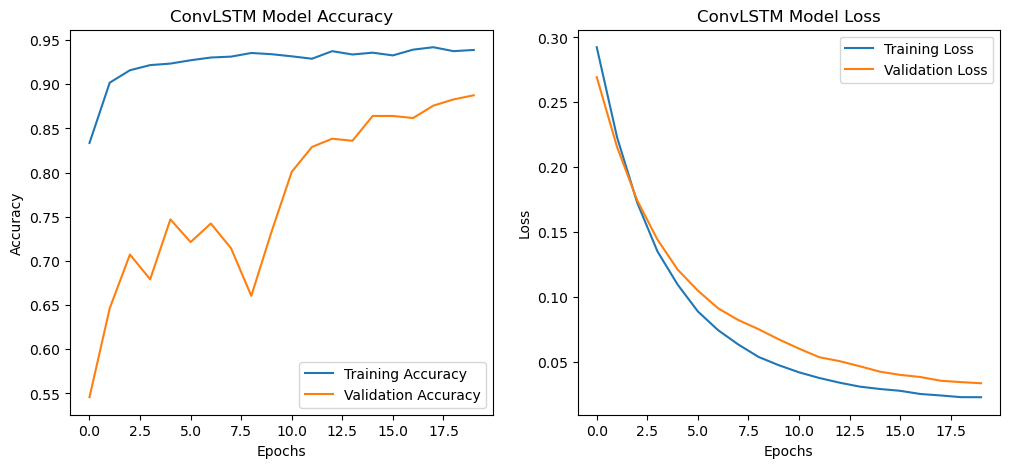

In [50]:
plt.figure(figsize=(12, 5))
#plt.title('Accuracy and Loss of ConvLSTM Model')


# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(convlstm_history.history['accuracy'], label='Training Accuracy')
plt.plot(convlstm_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('ConvLSTM Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(convlstm_history.history['loss'], label='Training Loss')
plt.plot(convlstm_history.history['val_loss'], label='Validation Loss')
plt.title('ConvLSTM Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()